![Back-Market-logo](./resources/images/Back_Market_logo.png)

# Back Market Data Engineering technical assessment - Thibault Latrace

This notebook focuses on the Back Market collect-prepare technical assessment, whose wording can be found in this [GitHub repository](https://github.com/BackMarket/jobs/tree/master/data_prepare_team). <br>
Note : this notebook is only used for experimentation, not production : the final transformer script will be written in a proper python file.

My strategy to solve the problem is the following :

- I. Exploration of the CSV file.
- II. Transformation of a file from CSV to Parquet format.
- III. Splitting of the given CSV file into the two expected Parquet files.
- IV. Exploration of a scaling strategy.
- V. Comparison of the scaling strategy to the initial one.

Let's dive into it !

In [1]:
import pandas as pd
import dask.dataframe as dd
import time

from pathlib import Path
from loguru import logger
from typing import Union

### I. Exploration of the product_catalog.csv file

In [2]:
input_filepath = Path("./resources/product_catalog.csv")
df = pd.read_csv(input_filepath)

In [3]:
print(f"Number of rows : {df.shape[0]}")
print(f"Number of columns : {df.shape[1]}\n")

df.describe(include = "all")

Number of rows : 1000
Number of columns : 7



,brand,category_id,comment,currency,description,image,year_release
count,1000,1000.000000,929,1000,837,740,1000.000000
unique,6,NaN,685,105,2,516,NaN
top,HP,NaN,Proin risus. Praesent lectus. Vestibulum quam ...,CNY,Female,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN
freq,175,NaN,5,196,421,4,NaN
mean,NaN,50.780000,NaN,NaN,NaN,NaN,1999.873000
std,NaN,28.695383,NaN,NaN,NaN,NaN,9.599011
min,NaN,1.000000,NaN,NaN,NaN,NaN,1955.000000
25%,NaN,26.000000,NaN,NaN,NaN,NaN,1994.000000
50%,NaN,50.000000,NaN,NaN,NaN,NaN,2001.000000
75%,NaN,76.000000,NaN,NaN,NaN,NaN,2007.000000


In [4]:
df.head(10)

,brand,category_id,comment,currency,description,image,year_release
0,Toshiba,71,NaN,NOK,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",1993
1,HP,99,Suspendisse accumsan tortor quis turpis.,PEN,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",1988
2,Acer,69,Donec dapibus. Duis at velit eu est congue ele...,IDR,Female,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2010
3,HP,62,NaN,CNY,Female,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2008
4,Dell,48,Vivamus in felis eu sapien cursus vestibulum. ...,CNY,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2013
5,Dell,93,Aliquam quis turpis eget elit sodales sceleris...,IDR,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2000
6,HP,87,Mauris lacinia sapien quis libero. Nullam sit ...,CNY,NaN,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",1991
7,Acer,32,NaN,ARS,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2007
8,Samsung,97,Nulla suscipit ligula in lacus. Curabitur at i...,AFN,Female,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2001
9,Lenovo,5,Donec posuere metus vitae ipsum. Aliquam non m...,ILS,Female,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",1985


In [5]:
print(f"Number of categories: {len(df['category_id'].unique())}")
print(f"Number of year releases: {len(df['year_release'].unique())}")
print(f"Brands name: {df['brand'].unique()}")

Number of categories: 100
Number of year releases: 50
Brands name: ['Toshiba' 'HP' 'Acer' 'Dell' 'Samsung' 'Lenovo']


Let's check for duplicates :

In [6]:
df[df.duplicated() == True]

,brand,category_id,comment,currency,description,image,year_release


**A few interesting observations :**

- around 75% of the products have an image (740 out of 1000) : we should expect the valid file to have 740 rows and the invalid file to have 260 rows

- there are only 6 brands, which looks okay.

- there are 105 different currencies, which looks like a lot. However, there are 164 official national currencies circulating around the world, so it doesn't sound impossible neither.
 
- some images have duplicates : there are 740 images but only 516 are unique. It looks unusual for different products to have the same picture : it could be the sign of product duplicates. However, after checking the image links, they are leading to fake picture so we can considerate that several were used multiple times for the case study.

### II. Transformation of the file from CSV to Parquet format.

In [7]:
def save_pandas_dataframe_to_parquet(df: Union[pd.DataFrame, pd.Series], output_filepath: Path) -> None:
    if not output_filepath.exists():
        df.to_parquet(output_filepath, compression="gzip")
    else:
        raise ValueError(f"The file was not created because the following output filepath already exists : '{output_filepath}'")

In [10]:
output_filepath = Path("./product_catalog.parquet")
save_pandas_dataframe_to_parquet(df, output_filepath)

In [11]:
input_file_size = round(input_filepath.stat().st_size / 10e3)
output_file_size = round(output_filepath.stat().st_size / 10e3)
print(f"CSV input file size : {input_file_size} Ko")
print(f"Parquet output file size : {output_file_size} Ko")
print(f"Size was reduced by a factor {round(input_file_size/output_file_size, 1)}.")

CSV input file size : 91 Ko
Parquet output file size : 43 Ko
Size was reduced by a factor 2.1.


### III. Splitting of the CSV file into the two expected Parquet files.

In [14]:
valid_df = df[df["image"].notnull()]
invalid_df = df[df["image"].isnull()]

valid_file_output_path = Path("./valid_product_catalog.parquet")
invalid_file_output_path = Path("./invalid_product_catalog.parquet")

save_pandas_dataframe_to_parquet(valid_df, valid_file_output_path)
save_pandas_dataframe_to_parquet(invalid_df, invalid_file_output_path)

### IV. Exploring a scaling strategy.

Dask is a Python library used for parallel computing. Let's use it to parallelize the CSV reading on large CSV files.

Let's build a bigger CSV file from the one given, by replicating its lines a given number of times. This is for test purpose only. <br>
*Note* : this operation can take a few minutes. It is not meant to be used in production environment and should be run only once.

In [15]:
def scale_csv_file(csv_input_filepath: Path, scaled_csv_output_filepath: Path, scaling_factor: int) -> None:
    df = pd.read_csv(csv_input_filepath)
    scaled_df = pd.concat([df]*scaling_factor, ignore_index=True)
    if not scaled_csv_output_filepath.exists():
        scaled_df.to_csv(scaled_csv_output_filepath, index=False)
    else:
        raise ValueError(f"The file was not created because the following output filepath already exists : '{scaled_csv_output_filepath}'")

In [17]:
%%time

csv_input_filepath = Path("./resources/product_catalog.csv")
scaled_csv_output_filepath = Path("./scaled_product_catalog.csv")
scaling_factor = 1000
scale_csv_file(csv_input_filepath, scaled_csv_output_filepath, scaling_factor)

CPU times: user 48.2 s, sys: 2.2 s, total: 50.4 s
Wall time: 1min 38s


Let's visualize the task graph to see how Dask parallelizes the function read_csv.

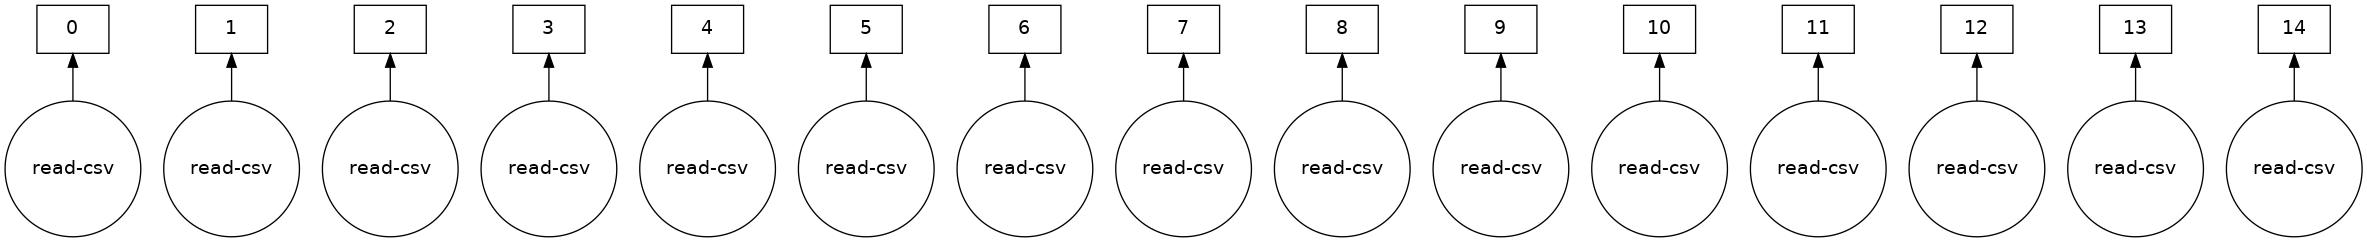

In [18]:
ddf = dd.read_csv(scaled_csv_output_filepath)

ddf.visualize()

With this strategy, the dataframe is read with 14 parallel workers. Now, let's separate the dask dataframe into two valid and invalid ones.

In [19]:
valid_ddf = ddf[ddf["image"].notnull()]
invalid_ddf = ddf[ddf["image"].isnull()]

For now, the two dataframes are not computed yet. Let's see how the valid dask dataframe will be computed.

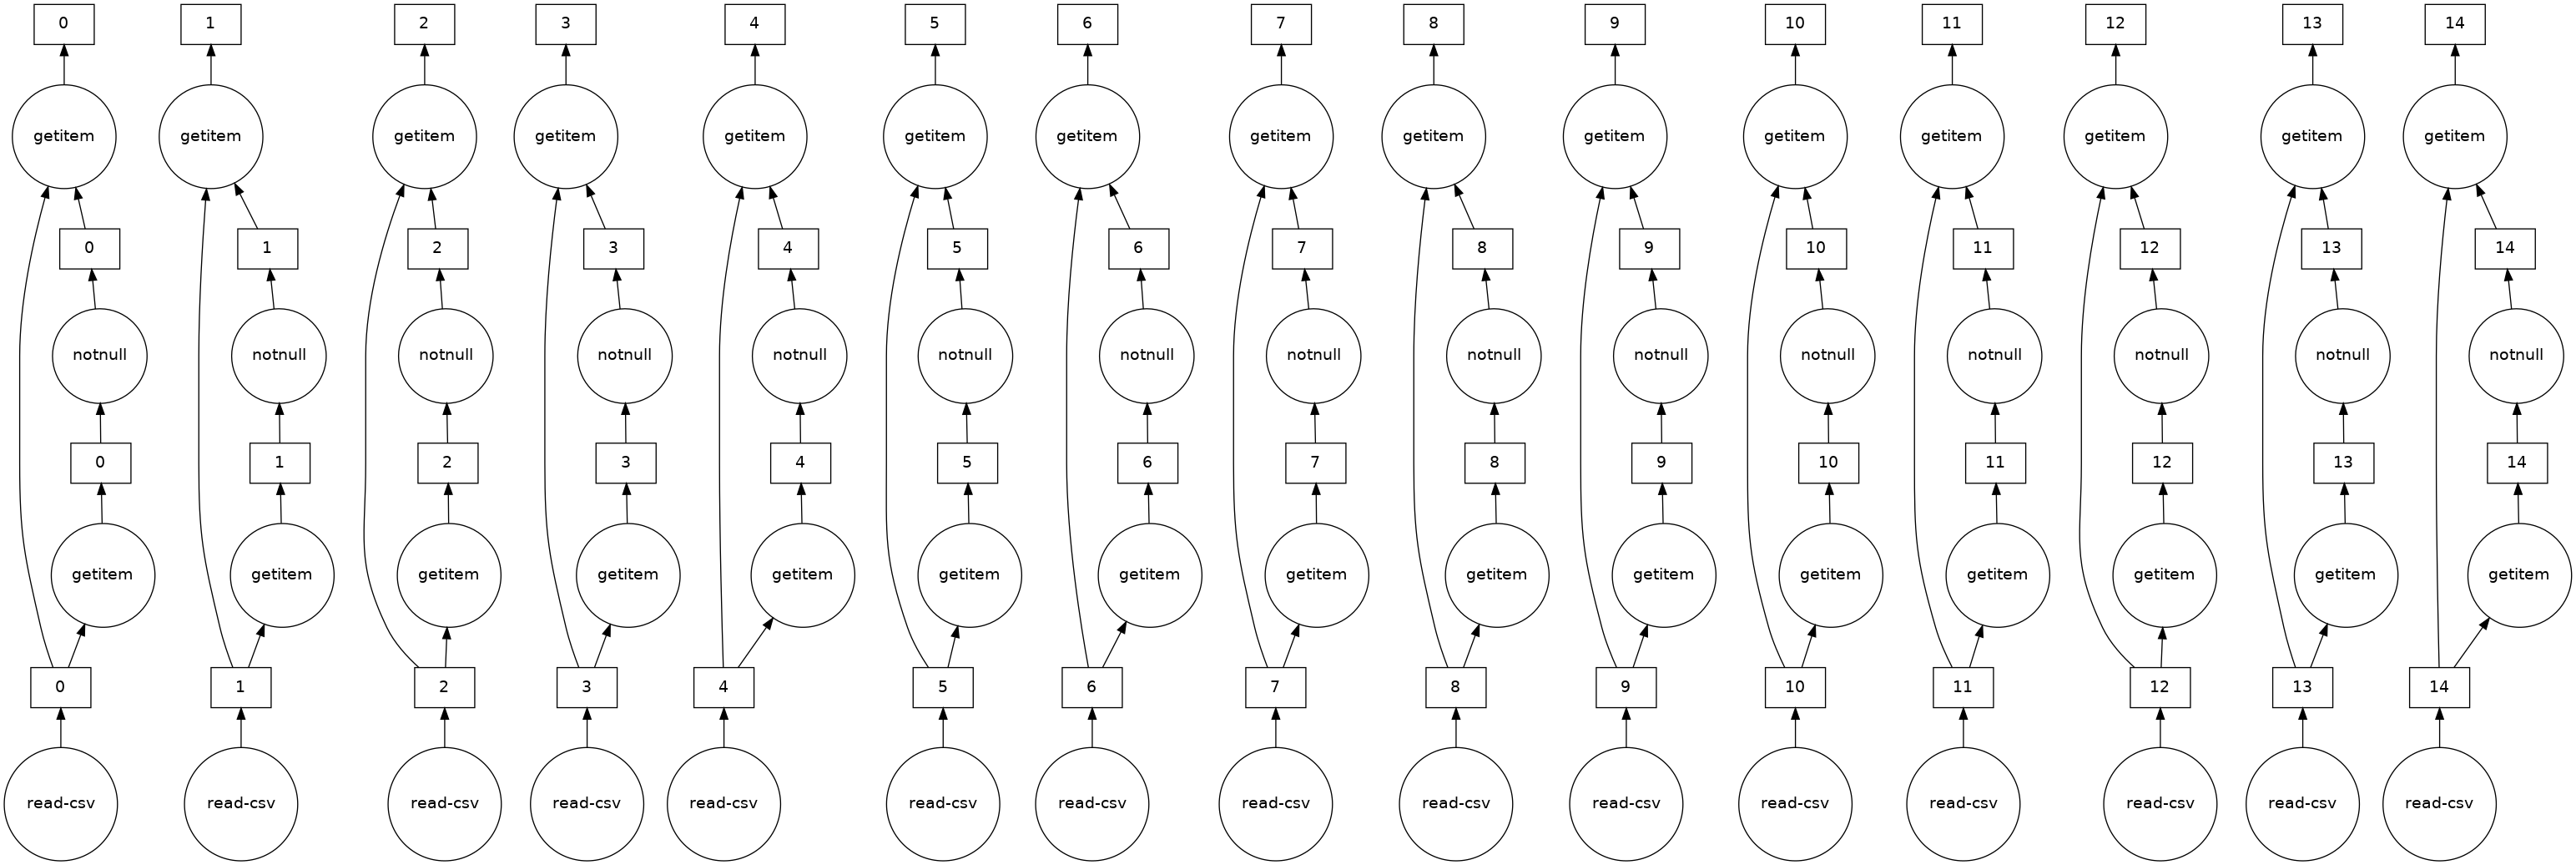

In [20]:
valid_ddf.visualize()

Finally, let's use the to_parquet() method on the two dask dataframes. Note that the computation will only take place now.

In [21]:
def save_dask_dataframe_to_parquet(ddf: dd.DataFrame, output_parquet_filepath: Path) -> None:
    if not output_parquet_filepath.exists():
        dd.to_parquet(ddf, output_parquet_filepath)
    else:
        raise ValueError(f"The file was not created because the following output filepath already exists : '{output_parquet_filepath}'")

In [24]:
%%time

scaled_valid_file_output_path = Path("./valid_scaled_product_catalog.parquet")
scaled_invalid_file_output_path = Path("./invalid_scaled_product_catalog.parquet")

save_dask_dataframe_to_parquet(valid_ddf, scaled_valid_file_output_path)
save_dask_dataframe_to_parquet(invalid_ddf, scaled_invalid_file_output_path)

CPU times: user 32.9 s, sys: 10.7 s, total: 43.5 s
Wall time: 53.6 s


### V. Comparison of the two methods.

With pandas method :

In [29]:
start_time = time.time()

input_filepath = Path("./scaled_product_catalog.csv")
pandas_valid_output_filepath = Path("./pandas_valid_scaled_product_catalog.parquet")
pandas_invalid_output_filepath = Path("./pandas_invalid_scaled_product_catalog.parquet")

df = pd.read_csv(input_filepath)
valid_df = df[df["image"].notnull()]
invalid_df = df[df["image"].isnull()]

save_pandas_dataframe_to_parquet(valid_df, pandas_valid_output_filepath)
save_pandas_dataframe_to_parquet(invalid_df, pandas_invalid_output_filepath)

pandas_method_time = time.time() - start_time
print(f"The script took {round(pandas_method_time)}s to execute")

The script took 84s to execute


With scaling Dask method :

In [30]:
start_time = time.time()

input_filepath = Path("./scaled_product_catalog.csv")
dask_valid_output_filepath = Path("./dask_valid_scaled_product_catalog.parquet")
dask_invalid_output_filepath = Path("./dask_invalid_scaled_product_catalog.parquet")

ddf = dd.read_csv(input_filepath)
valid_ddf = ddf[ddf["image"].notnull()]
invalid_ddf = ddf[ddf["image"].isnull()]

save_dask_dataframe_to_parquet(valid_ddf, dask_valid_output_filepath)
save_dask_dataframe_to_parquet(invalid_ddf, dask_invalid_output_filepath)

dask_method_time = time.time() - start_time
print(f"The script took {round(dask_method_time)}s to execute")

The script took 56s to execute


In [32]:
print(f"Using Dask reduced the execution time by a factor {round(pandas_method_time/dask_method_time, 1)}")

Using Dask reduced the execution time by a factor 1.5


As a result, using Dask parallel computing library could enable to transform the CSV file to two Parquet files faster than the pandas library.

![Back-Market-logo](./resources/images/Back_Market_logo.png)